In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from port_tide_window import TideWindow
from datetime import datetime, timedelta

In [122]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Validate Tide Window

(0.0, 344.0)

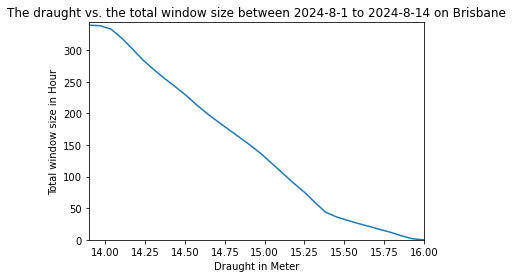

In [61]:
tide_df = pd.read_csv('../tide_heights.csv')
tw = TideWindow(tide_df)
plot_x = []
plot_y = []
for i in np.linspace(-0.3, 3):
    interval_df = tw.find_tide_window(i, 'Brisbane', start_time=datetime(2024,8,1,0,0,0))
    interval_df['DURATION'] = (interval_df['END_DATETIME'] - interval_df['START_DATETIME']).apply(lambda x: x.total_seconds()/3600)
    plot_x.append(i)
    plot_y.append(interval_df['DURATION'].sum())
plt.plot(np.array(plot_x) + 14, plot_y)
plt.title('The draught vs. the total window size between 2024-8-1 to 2024-8-14 on Brisbane')
plt.xlabel("Draught in Meter")
plt.ylabel("Total window size in Hour")
plt.xlim([13.9, 16])
plt.ylim([0, 344])

This chart illustrates the window size for a ship with different draught. Intuitively, the ship with higher draught should have a smaller window, until the draught is too deep to dock on the harbour. As the piece-wise method was applied to the tide interpolation, we expect some turning at the top-left and bottom-right of the chart. 

## Handling Missing Data

In [115]:
import matplotlib.dates as mdates
ap_tide_df = tide_df.loc[(tide_df['PORT_NAME']=='Abbot Point') & 
                         (tide_df['TIDE_DATETIME'] < '2024-03-06 00:00:00') & 
                         (tide_df['TIDE_DATETIME'] > '2024-03-01 00:00:00')]
ap_tide_df['TIDE_HEIGHT_MT'] = ap_tide_df['TIDE_HEIGHT_MT'].apply(lambda x: x + 17.2)
high_tide_df = ap_tide_df.loc[ap_tide_df['TIDE_TYPE']=='HIGH']
low_tide_df = ap_tide_df.loc[ap_tide_df['TIDE_TYPE']=='LOW']
interval_df = tw.find_tide_window(1, 'Abbot Point', start_time=datetime(2024,3,1,0,0,0), window_length=timedelta(days=5))

C:\Users\roddi\AppData\Local\Temp/ipykernel_27976/1030224067.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_tide_df['TIDE_HEIGHT_MT'] = ap_tide_df['TIDE_HEIGHT_MT'].apply(lambda x: x + 17.2)


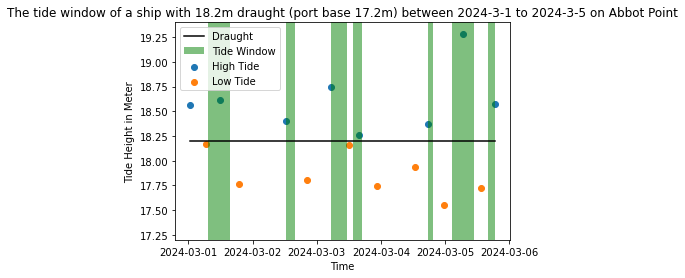

In [116]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.scatter(high_tide_df['TIDE_DATETIME'], high_tide_df['TIDE_HEIGHT_MT'], label='High Tide')
plt.scatter(low_tide_df['TIDE_DATETIME'], low_tide_df['TIDE_HEIGHT_MT'], label='Low Tide')
plt.axvspan(interval_df.values[0, 0], interval_df.values[0, 1], facecolor='g', alpha=0.5, label='Tide Window')
for interval in interval_df.values[1:]:
    plt.axvspan(interval[0], interval[1], facecolor='g', alpha=0.5)
plt.plot(high_tide_df['TIDE_DATETIME'], [18.2] * high_tide_df['TIDE_DATETIME'].shape[0], label='Draught', color='black')
plt.ylim([17.2, 19.4])
plt.title('The tide window of a ship with 18.2m draught (port base 17.2m) between 2024-3-1 to 2024-3-5 on Abbot Point')
plt.xlabel("Time")
plt.ylabel("Tide Height in Meter")
plt.legend(loc=2)

The chart shows the tide window from 2024-3-1 to 2024-3-5 of a ship with 18.2m draught. Please notice that there are data missing on 2024-03-02 and 2024-03-04. Therefore, there is no window is recommeded by the API when there is a missing point.  

# Validate Daylight Window

In [117]:
import pandas as pd
from daylight_window import DayLightWindow
from utils import Intervals
port_df = pd.read_csv('../ports.csv')
dlw = DayLightWindow(port_df)
daylight_df = dlw.find_daylight_window('Abbot Point', start_date=datetime(2024,3,1,0,0,0), window_length=timedelta(days=5))
tide_intervals = Intervals(list(interval_df.itertuples(index=False, 
                                                       name=None)))
tide_daylight_intervals = tide_intervals.intersect(list(daylight_df.itertuples(index=False, 
                                                                               name=None)))
tide_daylight_df = pd.DataFrame(tide_daylight_intervals, columns=['START_DATETIME', 'END_DATETIME'])

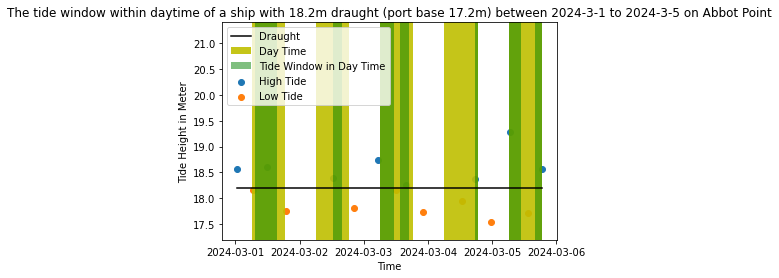

In [119]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.axvspan(daylight_df.values[0, 0], daylight_df.values[0, 1], facecolor='y', alpha=0.9, label='Day Time')
for interval in daylight_df.values[1:-1]:
    plt.axvspan(interval[0], interval[1], facecolor='y', alpha=0.9)
plt.axvspan(tide_daylight_df.values[0, 0], tide_daylight_df.values[0, 1], facecolor='g', alpha=0.5, label='Tide Window in Day Time')
for interval in tide_daylight_df.values[1:]:
    plt.axvspan(interval[0], interval[1], facecolor='g', alpha=0.5)
plt.scatter(high_tide_df['TIDE_DATETIME'], high_tide_df['TIDE_HEIGHT_MT'], label='High Tide')
plt.scatter(low_tide_df['TIDE_DATETIME'], low_tide_df['TIDE_HEIGHT_MT'], label='Low Tide')


plt.plot(high_tide_df['TIDE_DATETIME'], [18.2] * high_tide_df['TIDE_DATETIME'].shape[0], label='Draught', color='black')
plt.ylim([17.2, 21.4])
plt.title('The tide window within daytime of a ship with 18.2m draught (port base 17.2m) between 2024-3-1 to 2024-3-5 on Abbot Point')
plt.xlabel("Time")
plt.ylabel("Tide Height in Meter")
plt.legend(loc=2)

The chart shows the tide window in the daytime from 2024-3-1 to 2024-3-5 of a ship with 18.2m draught. please notice the green area is within the day time of the port, and much smaller than the area on 2024-3-5 in the previous chart, which suggests the effectiveness of the API. 